In [237]:
import requests
from requests import get as req_get
from json import dump, load
from matplotlib import pyplot as plt
from PIL import Image
from io import BytesIO
import base64

In [238]:
class Parser:
    URL = "https://author.today/top/writers"
    ENCODING = "utf-8"
    AUTHOR_DIVIDER = '<div class="profile-card" data-pjax>'
    file_name = "authors_data.json"

    def __init__(self):
        self.authors = []

    def _get_page(self, i):
        response = req_get(self.URL, params={"page": i})
        response.encoding = self.ENCODING
        return response.text

    def _get_author_cards(self, page_num):
        page = self._get_page(page_num)
        authors = page.split(self.AUTHOR_DIVIDER)
        return authors[1:]

    def _parse_element(self, text, start_index, start_text, end_text):
        element_start_index = text.find(start_text, start_index) + len(start_text)
        element_end_index = text.find(end_text, element_start_index)
        return text[element_start_index: element_end_index], element_end_index

    def get_parsed_authors(self):
        return load(open(self.file_name, 'r', encoding=self.ENCODING))

    def parse_authors(self, start_page=1, last_page=1):
        for page_number in range(start_page, last_page + 1):
            print(f"page number {page_number} has been processed")
            author_cards = self._get_author_cards(page_number)
            for author_card in author_cards:
                ##parsing image
                img_start_text = '<img class="" src="'
                img_end_text = '?width=70'
                author_img, end_index = self._parse_element(author_card, 0, img_start_text, img_end_text)
                if end_index != -1:
                    #print(author_img, type(author_img), end_index)
                    base64_imgdata = base64.b64encode(author_img.encode('utf-8'))
                    decoded_image = base64.b64decode(base64_imgdata)
                    b64_image = base64.b64encode(decoded_image).decode('utf-8')
                    data_img = {'image': b64_image}
                else:
                    data_img = {'image': "noimage"}

                ##parsing name
                name_start_text = '<span class="text-truncate">'
                name_end_text = '</span>'
                author_name, end_index = self._parse_element(author_card, 0, name_start_text, name_end_text)
                # print(author_name)
                
                ##parsing rating
                rating_start_text = '<i class="icon-author-rating text-bold"></i> '
                rating_end_text = '</span>'
                author_rating, end_index = self._parse_element(author_card, end_index, rating_start_text, rating_end_text)
                # author_rating = author_rating.encode(self.ENCODING).decode(self.ENCODING)
                # print(author_rating.strip())
                
                ##parsing subscribers
                subscribers_start_text = '<i class="icon-favorite"></i> '
                subscribers_end_text = rating_end_text
                author_subs, end_index = self._parse_element(author_card, end_index, subscribers_start_text, subscribers_end_text)
                # print(author_subs)
                
                ##parsing books
                authors_books_start_text = '<i class="icon-book2"></i> '
                authors_books_end_text = rating_end_text
                author_books, end_index = self._parse_element(author_card, end_index, authors_books_start_text, authors_books_end_text)
                # print(author_books)
                
                ##parsing link
                link_start_text = '<a href="'
                link_end_text = '" class="'
                link_to_author, end_index = self._parse_element(author_card, 0, link_start_text, link_end_text)
                # print(link_to_author)
                
                author = {"img": data_img,
                          "link": link_to_author,
                          "name": author_name,
                          "rating": author_rating.strip().replace(u'\xa0', ''),
                          "subs": author_subs.strip().replace('K', '000').replace('\xa0', ''),
                          "books": author_books.strip().replace('\xa0', '')}
                self.authors.append(author)
                
        #self.save_to_file()
            
    def save_to_file(self):
         dump(self.authors, open(self.file_name, "w", encoding=self.ENCODING))

In [239]:
class Visualizer:
    def __init__(self, parser):
        self.parser = parser

    def draw_stat(self, key, label, start_index=0, last_index=10000):
        authors = self.parser.get_parsed_authors()[start_index: last_index + 1]
        main_stat = [int(author[key]) for author in authors][start_index: last_index + 1]
        figure, axis = plt.subplots()
        x_data = list(range(last_index, start_index - 1, -1))
        # print(x_data)
        # print(main_stat)
        # axis.legend()
        axis.grid()
        axis.set_title(label)
        axis.plot(x_data, list(reversed(main_stat)), label=label)
        plt.show()
    
    def draw_authors_image(self, authors_index):
        authors = self.parser.get_parsed_authors()[:authors_index + 1][authors_index]
        author_image = authors['img']['image']
        if author_image == "noimage":
            return f"Top {authors_index + 1} author has no image on his profile"
        #print(f"author_image: {author_image}, type: {type(author_image)}")
        response = requests.get(base64.b64decode(author_image))
        return Image.open(BytesIO(response.content))

    def draw_authors_rating(self, start_index=0, last_index=10000):
        self.draw_stat('rating', 'Рейтинг авторов', start_index, last_index)

    def draw_amount_of_subs(self, start_index=0, last_index=10000):
        self.draw_stat('subs', 'Подписчики авторов', start_index, last_index)

    def draw_amount_of_books(self, start_index=0, last_index=10000):
        self.draw_stat('books', 'Книги авторов', start_index, last_index)

In [240]:
parser = Parser()

In [241]:
parser.parse_authors(1, 2)
parser.save_to_file()

page number 1 has been processed
page number 2 has been processed


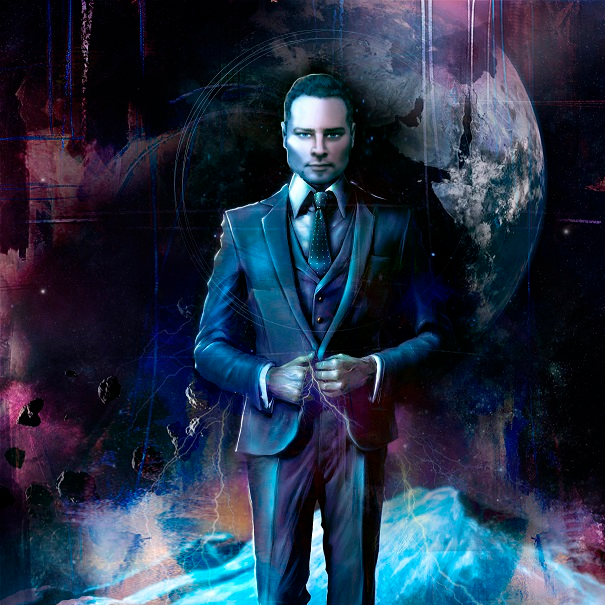

In [242]:
visualizer = Visualizer(parser)
visualizer.draw_authors_image(1)

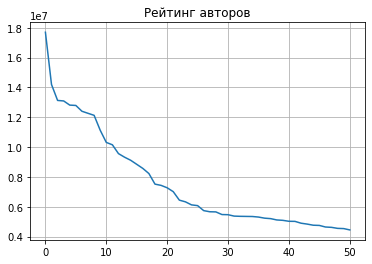

In [243]:
visualizer = Visualizer(parser)
visualizer.draw_authors_rating(0, 50)

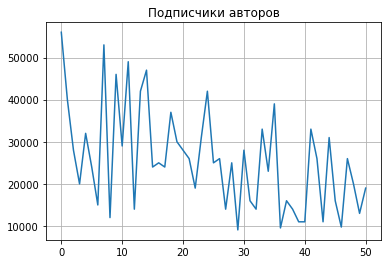

In [244]:
visualizer.draw_amount_of_subs(0, 50)

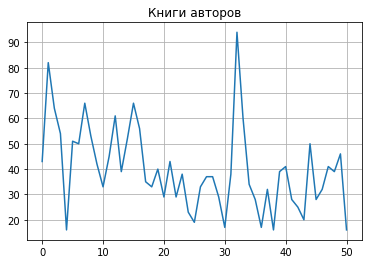

In [245]:
visualizer.draw_amount_of_books(0, 50)